# Algorithm for Sequential and Dynamic Association Rules Mining based on Apriori Algorithm and Markov Chain Model

### Saruultugs.B, Yibin.W

This notebook explores the application of sequential and dynamic association rule mining in the context of market basket analysis using a grocery dataset. The goal is to identify frequent itemsets, popular combinations of items purchased together, and potential purchase patterns over time.

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('Groceries_dataset.csv')

df_cleaned = df.groupby(['Member_number', 'Date'])['itemDescription'].agg(list).reset_index()

## Original Dataset

In [ ]:
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [ ]:
df_cleaned

,Member_number,Date,itemDescription
0,1000,15-03-2015,"[sausage, whole milk, semi-finished bread, yog..."
1,1000,24-06-2014,"[whole milk, pastry, salty snack]"
2,1000,24-07-2015,"[canned beer, misc. beverages]"
3,1000,25-11-2015,"[sausage, hygiene articles]"
4,1000,27-05-2015,"[soda, pickled vegetables]"
...,...,...,...
14958,4999,24-01-2015,"[tropical fruit, berries, other vegetables, yo..."
14959,4999,26-12-2015,"[bottled water, herbs]"
14960,5000,09-03-2014,"[fruit/vegetable juice, onions]"
14961,5000,10-02-2015,"[soda, root vegetables, semi-finished bread]"


 ### The distribution of the number of items purchased in each transaction.

In [ ]:
df_cleaned['item_count'] = df_cleaned['itemDescription'].apply(len)

In [ ]:
import plotly.express as px


fig = px.histogram(df_cleaned, x='item_count', text_auto=True,
                   labels={'item_count': 'Item Count', 'count': 'Frequency'},
                   title='Distribution of Item Counts')


fig.update_traces(textfont_size=12, textangle=0, textposition="outside")
fig.update_layout(title_x=0.5, xaxis_title='Item Count', yaxis_title='Frequency',
                  bargap=0.1, width = 800, height = 500)

fig.show()


### The frequency of individual items purchased, calculates the support for each item (how often it's bought)

In [ ]:
df_1item = df.groupby(['itemDescription'])['Member_number'].count().reset_index().rename(columns={'itemDescription':'1_item','Member_number': 'count'})
df_1item['support_1item'] = (df_1item['count'] / df_1item['count'].sum())
df_1item[df_1item['1_item'] == 'sausage']

### List of items purchased in a transaction and createing pairs of consecutive items within that list, and adds these pairs

In [ ]:
def get_2_itemsets(item_list):
    if not isinstance(item_list, list) or len(item_list) < 2:
        return []

    two_itemsets = []
    for i in range(len(item_list) - 1):
        two_itemsets.append([item_list[i], item_list[i+1]])
    return two_itemsets

df_cleaned['2-itemset'] = df_cleaned['itemDescription'].apply(get_2_itemsets)
df_cleaned

,Member_number,Date,itemDescription,2-itemset
0,1000,15-03-2015,"[sausage, whole milk, semi-finished bread, yog...","[[sausage, whole milk], [whole milk, semi-fini..."
1,1000,24-06-2014,"[whole milk, pastry, salty snack]","[[whole milk, pastry], [pastry, salty snack]]"
2,1000,24-07-2015,"[canned beer, misc. beverages]","[[canned beer, misc. beverages]]"
3,1000,25-11-2015,"[sausage, hygiene articles]","[[sausage, hygiene articles]]"
4,1000,27-05-2015,"[soda, pickled vegetables]","[[soda, pickled vegetables]]"
...,...,...,...,...
14958,4999,24-01-2015,"[tropical fruit, berries, other vegetables, yo...","[[tropical fruit, berries], [berries, other ve..."
14959,4999,26-12-2015,"[bottled water, herbs]","[[bottled water, herbs]]"
14960,5000,09-03-2014,"[fruit/vegetable juice, onions]","[[fruit/vegetable juice, onions]]"
14961,5000,10-02-2015,"[soda, root vegetables, semi-finished bread]","[[soda, root vegetables], [root vegetables, se..."


In [ ]:
from collections import defaultdict
# Initialize a dictionary to store 2-itemset counts
two_itemset_counts = defaultdict(int)

# Iterate through the '2-itemset' column
for index, row in df_cleaned.iterrows():
    itemsets = row['2-itemset']

    # Check if the value is a list, otherwise skip
    if isinstance(itemsets, list):
        for itemset in itemsets:
            # Convert the itemset to a tuple for hashability
            itemset_tuple = tuple(itemset)
            two_itemset_counts[itemset_tuple] += 1

In [ ]:
df_2items = pd.DataFrame.from_dict(two_itemset_counts, orient='index', columns=['count'])
df_2items.index.names = ['2_items']
df_2items = df_2items.reset_index()

In [ ]:
df_2items['support_2items'] = (df_2items['count']/ df_2items['count'].sum())

In [ ]:
df_2items

,2_items,count,support_2items
0,"(sausage, whole milk)",84,0.003529
1,"(whole milk, semi-finished bread)",8,0.000336
2,"(semi-finished bread, yogurt)",4,0.000168
3,"(whole milk, pastry)",45,0.001891
4,"(pastry, salty snack)",5,0.000210
...,...,...,...
7166,"(bottled water, decalcifier)",1,0.000042
7167,"(decalcifier, semi-finished bread)",1,0.000042
7168,"(yogurt, kitchen towels)",1,0.000042
7169,"(kitchen towels, napkins)",1,0.000042


In [ ]:
df_1item

,1_item,count,support_1item
0,Instant food products,60,0.001548
1,UHT-milk,323,0.008332
2,abrasive cleaner,22,0.000568
3,artif. sweetener,29,0.000748
4,baby cosmetics,3,0.000077
...,...,...,...
162,white bread,362,0.009338
163,white wine,176,0.004540
164,whole milk,2502,0.064543
165,yogurt,1334,0.034412


## Visualization

1. What are the most frequently purchased items over time?
2. What combinations are the most popular?
3. Correlation matrix for each items from top 20 frequently sold items. etc.

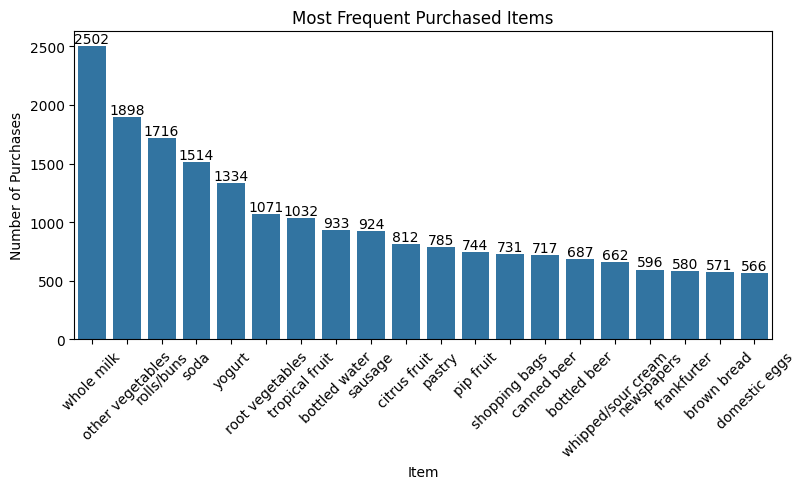

In [ ]:
# What are the most frequently purchased items over time?
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
ax = sns.barplot(x='1_item', y='count', data=df_1item.sort_values(by='count', ascending=False).head(20))
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.xlabel('Item')
plt.ylabel('Number of Purchases')
plt.title('Most Frequent Purchased Items')
plt.show()

In [ ]:
# What combinations are the most popular?
df_2items['2_items'] = df_2items['2_items'].apply(str)

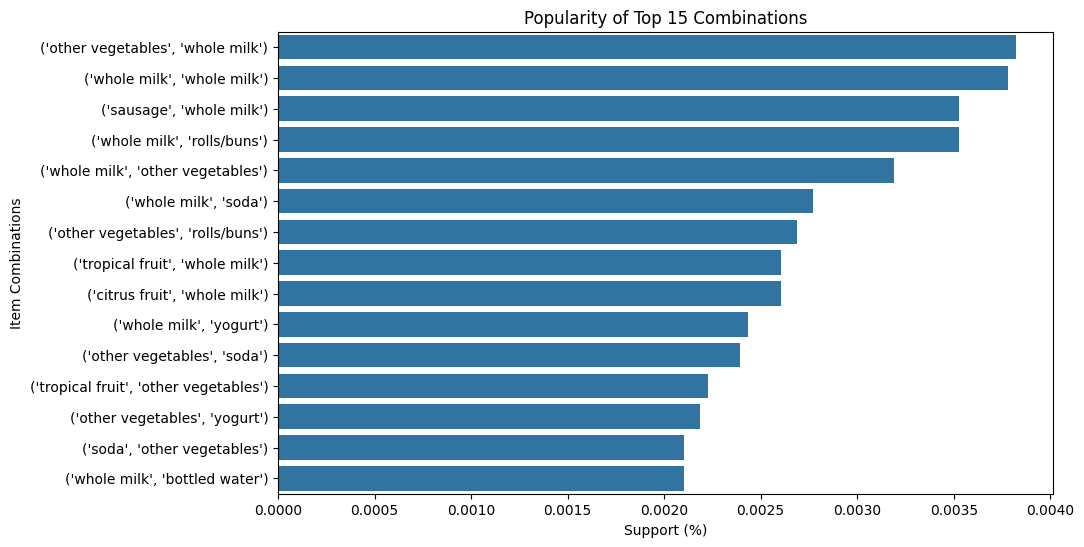

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top N combinations for the bar chart (e.g., top 10)
top_n = 15
df_top_combinations = df_2items.sort_values(by='support_2items', ascending=False).head(top_n)

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x='support_2items', y='2_items', data=df_top_combinations, orient='h')
plt.xlabel('Support (%)')
plt.ylabel('Item Combinations')
plt.title('Popularity of Top {} Combinations'.format(top_n))
plt.show()

In [ ]:
top_20_items = df_1item.sort_values(by='count', ascending=False).head(20)['1_item'].tolist()
filtered_df = df[df['itemDescription'].isin(top_20_items)]
transaction_matrix = pd.crosstab(filtered_df['Member_number'], filtered_df['itemDescription'])
correlation_matrix = transaction_matrix.corr()

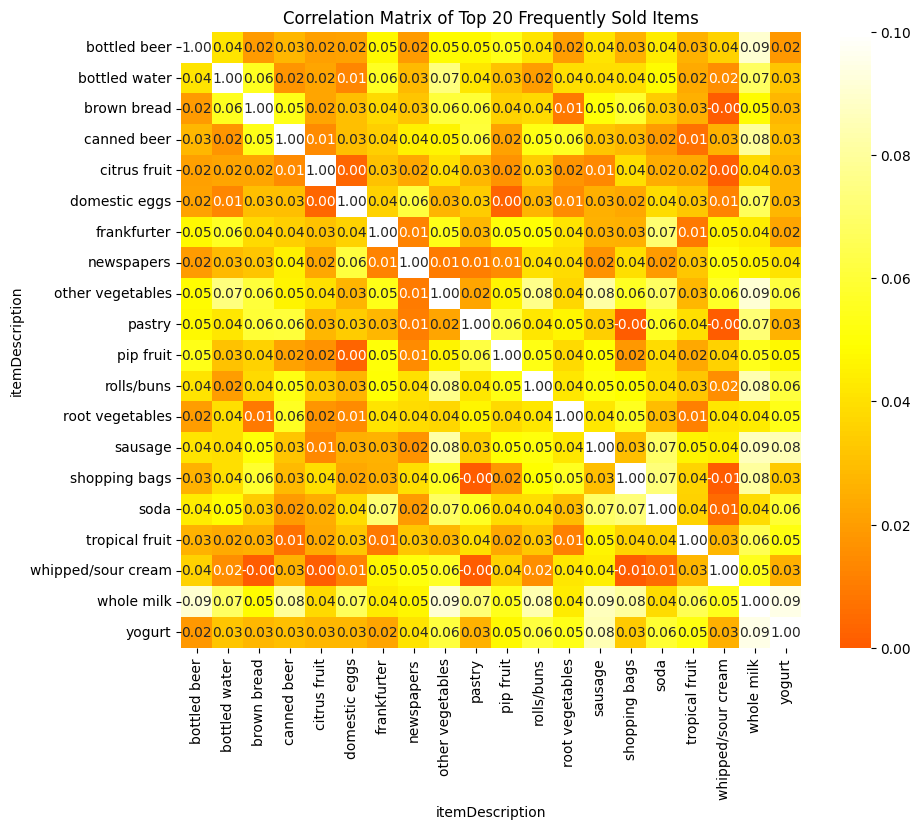

In [ ]:
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='hot', fmt=".2f", vmin=0, vmax=0.1, center=0)
plt.title('Correlation Matrix of Top 20 Frequently Sold Items')
plt.show()

## Implementation

In [ ]:
def calculate_purchase_probability(prior_item, target_item, df):
  # Filter for transactions containing the prior item
  prior_transactions = df[df['itemDescription'] == prior_item]['Member_number'].unique()
  # Filter for transactions containing both items by the same customer
  target_transactions = df[(df['itemDescription'] == target_item) & (df['Member_number'].isin(prior_transactions))]

  prior_count = len(prior_transactions)
  target_count = len(target_transactions)

  # Calculate probability
  if prior_count and prior_count > target_count:
    probability = target_count / prior_count
  else:
    probability = 0
  return probability

In [ ]:
from itertools import product

all_items = df['itemDescription'].unique()

probabilities = {}

for prior_item, target_item in product(all_items, all_items):
  if prior_item != target_item:
    p = calculate_purchase_probability(prior_item, target_item, df)
    probabilities[(prior_item, target_item)] = p

In [ ]:
prob_df = pd.DataFrame.from_dict(probabilities, orient='index', columns=['probability'])
prob_df.index.names = ['combinations']
prob_df = prob_df.reset_index()

In [ ]:
prob_df

,combinations,probability
0,"(tropical fruit, whole milk)",0.740944
1,"(tropical fruit, pip fruit)",0.217344
2,"(tropical fruit, other vegetables)",0.518112
3,"(tropical fruit, rolls/buns)",0.486279
4,"(tropical fruit, pot plants)",0.037322
...,...,...
27717,"(preservation products, specialty vegetables)",0.000000
27718,"(preservation products, pudding powder)",0.000000
27719,"(preservation products, ready soups)",0.000000
27720,"(preservation products, make up remover)",0.000000


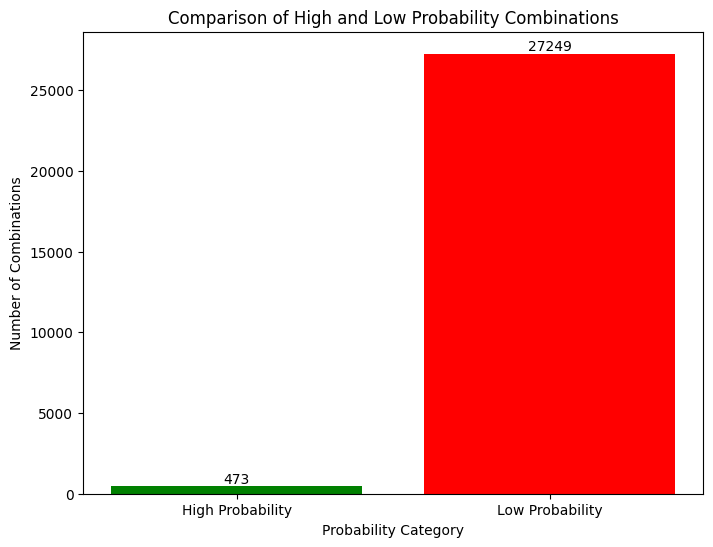

In [ ]:
import matplotlib.pyplot as plt

# Define the threshold for high and low probability
threshold = 0.5

# Count combinations with high and low probability
high_prob_count = len(prob_df[prob_df['probability'] >= threshold])
low_prob_count = len(prob_df[prob_df['probability'] < threshold])

# Create the bar plot
labels = ['High Probability', 'Low Probability']
counts = [high_prob_count, low_prob_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['green', 'red'])
plt.title('Comparison of High and Low Probability Combinations')
plt.xlabel('Probability Category')
plt.ylabel('Number of Combinations')

# Add labels to the bars
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


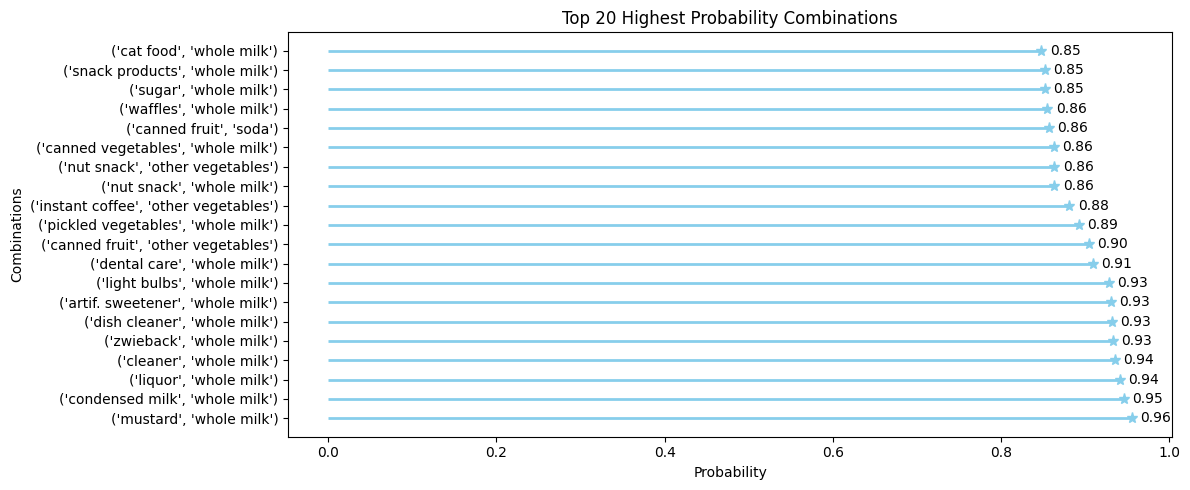

In [ ]:
# Sort the DataFrame by probability in descending order and get the top 20
top_20_combinations = prob_df.sort_values('probability', ascending=False).head(20)

# Extract combinations and probabilities for plotting
combinations = top_20_combinations['combinations'].apply(str).tolist()
probabilities = top_20_combinations['probability'].tolist()

# Create the lollipop plot
plt.figure(figsize=(12, 5))  # Adjust figure size as needed
# Create the lollipop plot
plt.hlines(y=combinations, xmin=0, xmax=probabilities, color='skyblue', linewidth=2)  # Horizontal lines
plt.plot(probabilities, combinations, "*", color='skyblue', markersize=8)  # Circles for lollipop heads
for i, prob in enumerate(probabilities):
       plt.text(prob + 0.01, combinations[i], f'{prob:.2f}', va='center')
plt.title('Top 20 Highest Probability Combinations')
plt.xlabel('Probability')
plt.ylabel('Combinations')
plt.tight_layout()
plt.show()

In [ ]:
# for validation, find all
from collections import Counter

# Initialize a Counter to store the frequencies
three_item_counter = Counter()

# Iterate through each list in the itemDescription column
for items in df_cleaned["itemDescription"]:
    # Generate all ordered 3-item combinations (sliding window of size 3)
    for i in range(len(items) - 2):
        three_item_combination = tuple(items[i:i+3])  # Create a tuple of 3 consecutive items
        three_item_counter[three_item_combination] += 1

# Convert the Counter to a DataFrame for easier viewing
three_item_counts_df = pd.DataFrame(three_item_counter.items(), columns=["3-item combination", "count"])

# Sort the DataFrame by count in descending order (optional)
three_item_counts_df = three_item_counts_df.sort_values(by="count", ascending=False)

# Print the resulting DataFrame
three_item_counts_df

,3-item combination,count
605,"(other vegetables, whole milk, soda)",4
3,"(sausage, whole milk, rolls/buns)",4
255,"(whole milk, frozen vegetables, soda)",4
515,"(whole milk, whole milk, whole milk)",4
665,"(citrus fruit, whole milk, rolls/buns)",4
...,...,...
2914,"(semi-finished bread, root vegetables, bottled...",1
2913,"(meat, semi-finished bread, root vegetables)",1
2912,"(frozen fish, meat, semi-finished bread)",1
2911,"(onions, frozen fish, meat)",1


In [ ]:
# Now we have count of each individual item as initial probability
# and count of each 2-item transitions as transitional probability
# To launch the algorithm, we first specify a threshold
p_threshold = 0.002
# Then we filter the 2-itme transitions
# for frequent 2-itemset


In [ ]:
df_for_prob_calc=df_2items.copy()
df_for_prob_calc['2_items'] = df_for_prob_calc['2_items'].apply(eval)

# Extract the first and second items from the tuples
df_for_prob_calc['first_item'] = df_for_prob_calc['2_items'].apply(lambda x: x[0])
df_for_prob_calc['second_item'] = df_for_prob_calc['2_items'].apply(lambda x: x[1])

# Define a function to calculate the probability of each second item given the first item
def calculate_conditional_probabilities(df, first_item_filter=None):
    if first_item_filter:
        filtered_df = df[df['first_item'] == first_item_filter]
    else:
        filtered_df = df

    # Group by 'first_item' and 'second_item' to calculate counts
    total_counts = filtered_df.groupby('first_item')['count'].sum()
    second_item_counts = filtered_df.groupby(['first_item', 'second_item'])['count'].sum()

    # Calculate probabilities
    probabilities = second_item_counts / total_counts

    return probabilities.reset_index(name='probability')

# Arrive at 1-step transition probability through conditional probability
transition_probabilities = calculate_conditional_probabilities(df_for_prob_calc)



In [ ]:
transition_probabilities

,first_item,second_item,probability
0,Instant food products,bottled beer,0.050000
1,Instant food products,butter milk,0.050000
2,Instant food products,coffee,0.050000
3,Instant food products,domestic eggs,0.050000
4,Instant food products,jam,0.050000
...,...,...,...
7166,zwieback,specialty chocolate,0.027778
7167,zwieback,tropical fruit,0.027778
7168,zwieback,white bread,0.027778
7169,zwieback,whole milk,0.027778


In [ ]:
# initial probability included in df_1item earlier
df_1item

,1_item,count,support_1item
0,Instant food products,60,0.001548
1,UHT-milk,323,0.008332
2,abrasive cleaner,22,0.000568
3,artif. sweetener,29,0.000748
4,baby cosmetics,3,0.000077
...,...,...,...
162,white bread,362,0.009338
163,white wine,176,0.004540
164,whole milk,2502,0.064543
165,yogurt,1334,0.034412


In [ ]:
df_2items

,2_items,count,support_2items
0,"('sausage', 'whole milk')",84,0.003529
1,"('whole milk', 'semi-finished bread')",8,0.000336
2,"('semi-finished bread', 'yogurt')",4,0.000168
3,"('whole milk', 'pastry')",45,0.001891
4,"('pastry', 'salty snack')",5,0.000210
...,...,...,...
7166,"('bottled water', 'decalcifier')",1,0.000042
7167,"('decalcifier', 'semi-finished bread')",1,0.000042
7168,"('yogurt', 'kitchen towels')",1,0.000042
7169,"('kitchen towels', 'napkins')",1,0.000042


In [ ]:
import ast

# Convert the string representations of tuples to actual tuples
df_2items["2_items"] = df_2items["2_items"].apply(ast.literal_eval)

In [ ]:
df_2items[["item1", "item2"]] = pd.DataFrame(df_2items["2_items"].tolist(), index=df_2items.index)
df_2items = df_2items.drop(columns=["2_items"])
df_2items = df_2items[["item1", "item2", "count","support_2items"]]

In [ ]:
frequent_2_item = df_2items[df_2items["support_2items"] >= p_threshold]
frequent_2_item = frequent_2_item.reset_index(drop=True)
frequent_2_item

,item1,item2,count,support_2items
0,sausage,whole milk,84,0.003529
1,whole milk,rolls/buns,84,0.003529
2,whole milk,soda,66,0.002773
3,other vegetables,yogurt,52,0.002185
4,citrus fruit,whole milk,62,0.002605
5,other vegetables,rolls/buns,64,0.002689
6,tropical fruit,other vegetables,53,0.002227
7,whole milk,yogurt,58,0.002437
8,whole milk,other vegetables,76,0.003193
9,other vegetables,soda,57,0.002395


In [ ]:
# Initialize an empty list to store rows for the new DataFrame
candidate_3_item_list = []

# Iterate over each row in frequent_2_item
for index, row in frequent_2_item.iterrows():
    # Find all rows where item1 matches the current row's item2
    matching_rows = frequent_2_item[frequent_2_item["item1"] == row["item2"]]

    # For each matching row, add a new entry to the candidate_3_item list
    for _, match in matching_rows.iterrows():
        candidate_3_item_list.append({
            "item1": row["item1"],
            "item2": row["item2"],
            "item3": match["item2"]
        })

# Create the new DataFrame
candidate_3_item = pd.DataFrame(candidate_3_item_list)

# Print the resulting DataFrame
candidate_3_item


,item1,item2,item3
0,sausage,whole milk,rolls/buns
1,sausage,whole milk,soda
2,sausage,whole milk,yogurt
3,sausage,whole milk,other vegetables
4,sausage,whole milk,whole milk
5,sausage,whole milk,bottled water
6,whole milk,soda,other vegetables
7,citrus fruit,whole milk,rolls/buns
8,citrus fruit,whole milk,soda
9,citrus fruit,whole milk,yogurt


In [ ]:
def calculate_theoretical_probability(row):
    # Step 1: Get initial probability
    initial_prob = df_1item.loc[df_1item["1_item"] == row["item1"], "support_1item"].values[0]

    # Step 2: Get first step transition probability
    first_step_prob = transition_probabilities.loc[
        (transition_probabilities["first_item"] == row["item1"]) &
        (transition_probabilities["second_item"] == row["item2"]),
        "probability"
    ].values[0]

    # Step 3: Get second step transition probability
    second_step_prob = transition_probabilities.loc[
        (transition_probabilities["first_item"] == row["item2"]) &
        (transition_probabilities["second_item"] == row["item3"]),
        "probability"
    ].values[0]

    # Step 4: Calculate theoretical probability
    return initial_prob * first_step_prob * second_step_prob

# Apply the function to each row of candidate_3_item
candidate_3_item["theoretical_probability"] = candidate_3_item.apply(calculate_theoretical_probability, axis=1)

# Print the updated DataFrame
candidate_3_item



,item1,item2,item3,theoretical_probability
0,sausage,whole milk,rolls/buns,0.000106
1,sausage,whole milk,soda,0.000083
2,sausage,whole milk,yogurt,0.000073
3,sausage,whole milk,other vegetables,0.000096
4,sausage,whole milk,whole milk,0.000114
5,sausage,whole milk,bottled water,0.000063
6,whole milk,soda,other vegetables,0.000138
7,citrus fruit,whole milk,rolls/buns,0.000087
8,citrus fruit,whole milk,soda,0.000069
9,citrus fruit,whole milk,yogurt,0.000060


In [ ]:
theoretical_3_item = candidate_3_item[candidate_3_item["theoretical_probability"] >= pow(p_threshold,2)]
theoretical_3_item = theoretical_3_item.reset_index(drop=True)
theoretical_3_item

,item1,item2,item3,theoretical_probability
0,sausage,whole milk,rolls/buns,0.000106
1,sausage,whole milk,soda,0.000083
2,sausage,whole milk,yogurt,0.000073
3,sausage,whole milk,other vegetables,0.000096
4,sausage,whole milk,whole milk,0.000114
5,sausage,whole milk,bottled water,0.000063
6,whole milk,soda,other vegetables,0.000138
7,citrus fruit,whole milk,rolls/buns,0.000087
8,citrus fruit,whole milk,soda,0.000069
9,citrus fruit,whole milk,yogurt,0.000060


In [ ]:
# Ensure the "3-item combination" column in three_item_counts_df is a tuple of (item1, item2, item3)
three_item_counts_df["3-item combination"] = three_item_counts_df["3-item combination"].apply(tuple)

# Create a "3-item combination" column in theoretical_3_item as a tuple of (item1, item2, item3)
theoretical_3_item["3-item combination"] = list(zip(
    theoretical_3_item["item1"],
    theoretical_3_item["item2"],
    theoretical_3_item["item3"]
))

# Merge theoretical_3_item with three_item_counts_df to find the counts
theoretical_3_item = theoretical_3_item.merge(
    three_item_counts_df,
    on="3-item combination",
    how="left"  # Use left join to keep all rows in theoretical_3_item even if no match is found
)

# Rename the count column for clarity
theoretical_3_item = theoretical_3_item.rename(columns={"count": "observed count"})

# Fill NaN values in "observed count" with 0 (for combinations not found in three_item_counts_df)
theoretical_3_item["observed count"] = theoretical_3_item["observed count"].fillna(0)

# Drop the "3-item combination" column if not needed
theoretical_3_item = theoretical_3_item.drop(columns=["3-item combination"])

# Print the updated DataFrame
theoretical_3_item


,item1,item2,item3,theoretical_probability,observed count
0,sausage,whole milk,rolls/buns,0.000106,4.0
1,sausage,whole milk,soda,0.000083,1.0
2,sausage,whole milk,yogurt,0.000073,2.0
3,sausage,whole milk,other vegetables,0.000096,2.0
4,sausage,whole milk,whole milk,0.000114,0.0
5,sausage,whole milk,bottled water,0.000063,1.0
6,whole milk,soda,other vegetables,0.000138,1.0
7,citrus fruit,whole milk,rolls/buns,0.000087,4.0
8,citrus fruit,whole milk,soda,0.000069,0.0
9,citrus fruit,whole milk,yogurt,0.000060,2.0


In [ ]:
theoretical_3_item['theoretical_probability'] = theoretical_3_item['theoretical_probability'] * 100

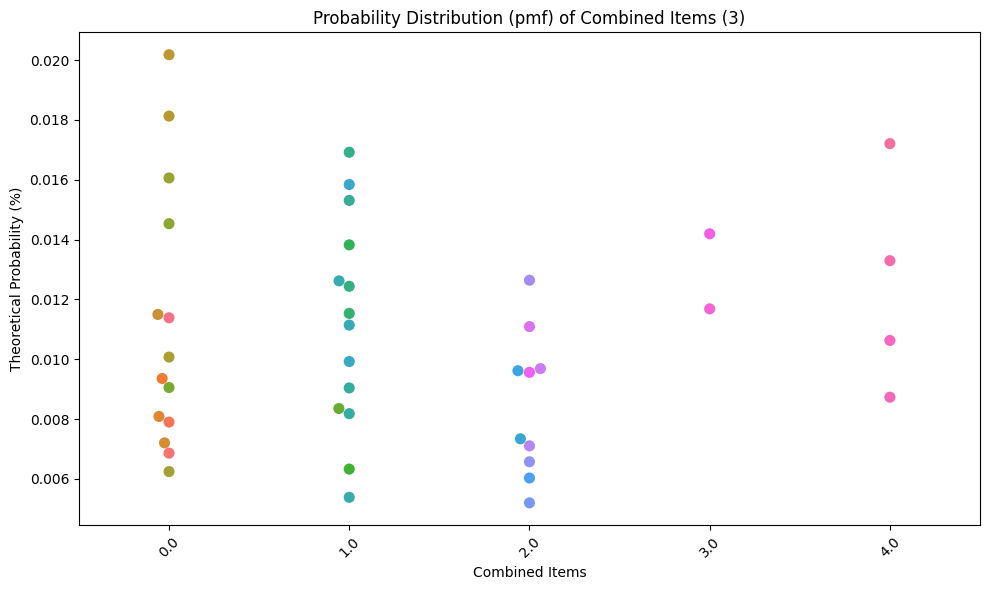

In [ ]:
# Combine the three item columns into a single column
theoretical_3_item['combined_items'] = theoretical_3_item['item1'] + ', ' + theoretical_3_item['item2'] + ', ' + theoretical_3_item['item3']

# Create the swarmplot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.swarmplot(x='observed count', y='theoretical_probability', hue = 'combined_items',legend = False, size = 8 ,data=theoretical_3_item)
plt.xticks(rotation=45)
plt.title('Probability Distribution (pmf) of Combined Items (3)')
plt.xlabel('Combined Items')
plt.ylabel('Theoretical Probability (%)')
plt.tight_layout()
plt.show()